# **Overview**

Sentiment analysis, a facet of Natural Language Processing, encompasses a range of methodologies designed to derive subjective insights from text or speech, including viewpoints and emotional tones. In essence, it revolves around categorizing text into positive, negative, or neutral sentiments.

Problem Statement:
The core aim of this endeavor is the identification and categorization of hate speech within tweets. To streamline the task, we define a tweet as being indicative of hate speech if it exhibits either racist or sexist sentiments. 

The main objective of this project is to detect instances of hate speech within tweets. To simplify the task, we consider a tweet to contain hate speech if it expresses either racist or sexist sentiments. 

To provide further details, this research is also be provided with a training dataset that includes tweets along with corresponding labels. Consequently, the task revolves around classifying tweets into three distinct categories:using the labels 'positive' will correspond to '2,' 'negative' to '1,' and 'neutral' to '0'.

# Import Libraries

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing

# Load the abusive and normalization CSV files
abusive_dict = pd.read_csv('abusive.csv', encoding='latin-1')
normalization_dict = pd.read_csv('normalization.csv', encoding='latin-1')

#For Preprocessing
import re    # RegEx for removing non-letter characters
import pickle 
import nltk  #natural language processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder

# Doc2Vec Model
import gensim.downloader as api
from gensim import models

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn import metrics
from collections import defaultdict
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USTER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USTER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


# **Exploratory Data Analysis**

# Data Review

In [3]:
# Load dataset
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)
# Output first five rows
df.columns =['text', 'label']
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
#Size of the data
df.shape

(11000, 2)

In [5]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


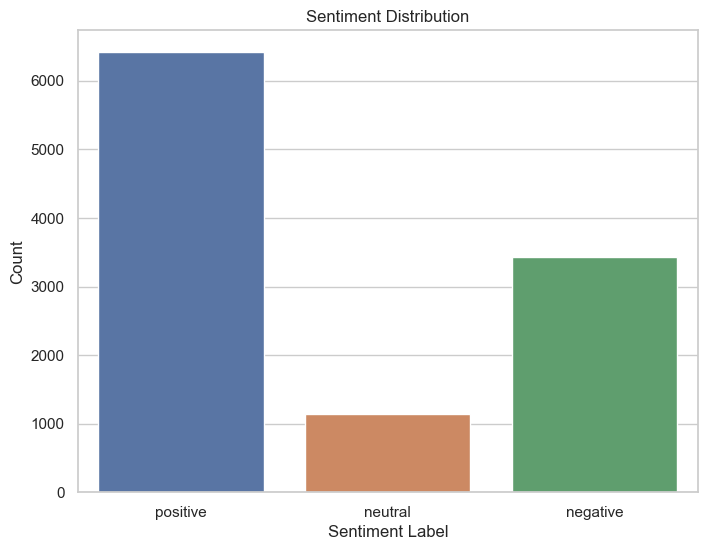

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [6]:
# Visualize sentiment using a count plot
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

df.label.value_counts()

# **Text Normalization/Cleansing**

The textual content frequently comprises hyperlinked text, emoticons, and punctuation marks. To facilitate their utilization for educational purposes via a Language Model, the incorporation of such content into the model's training data is impermissible. Consequently, it becomes necessary to undertake the purification of the textual data through the employment of diverse preprocessing and cleansing methodologies.

In [7]:
# Data Cleansing
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_unnecessary_char(text):
    # Remove unnecessary characters
    text = re.sub(r"\n", "", text)
    # Remove every username
    text = re.sub(r"user", "", text)
    # Remove URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    # Remove extra spaces
    text = re.sub('  +', ' ', text) 
    # Split a String
    text = re.sub(r"\s+", " ", text)
    # return list
    return text

# remove stopwords
# nltk.download('stopwords')
# stop = set(stopwords.words("indonesian"))
# def remove_stopwords(text):
#     filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
#     return " ".join(filtered_words)

# Transforming slang words "kata alay" into standard word
def normalize_alay(text):
    return ' '.join([normalization_dict[NORMALIZATION] if NORMALIZATION in normalization_dict else NORMALIZATION for NORMALIZATION in text.split(' ')])

def preprocess(text):
    text = remove_unnecessary_char(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    # text = remove_stopwords(text) # 3
    text = normalize_alay(text) # 4
    return text

In [8]:
# Check the text normalization
print("\nOriginal tweet ->", df['text'][0])
print("\nProcessed tweet ->", preprocess(df['text'][0]))


Original tweet -> warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !

Processed tweet -> warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka nya tidak kalah dengan yang asli dari tegal 


In [9]:
#Text already clean
df['text_clean'] = df.text.apply(preprocess)
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


# **Data Processing**

# Feature Extraction

The Doc2Vec model represents a significant enhancement over its predecessor, word2vec, by introducing an innovative unsupervised approach for generating vectors that encapsulate entire sentences, paragraphs, or documents. This evolution builds upon the foundations of word2vec while incorporating a distinctive facet: the inclusion of a supplementary context that is tailored to each document within the collection. This supplementary context manifests as an individual feature vector, dedicated to representing the entire document. Importantly, this document vector undergoes training in tandem with the word vectors, enhancing the model's ability to capture nuanced relationships within the corpus.

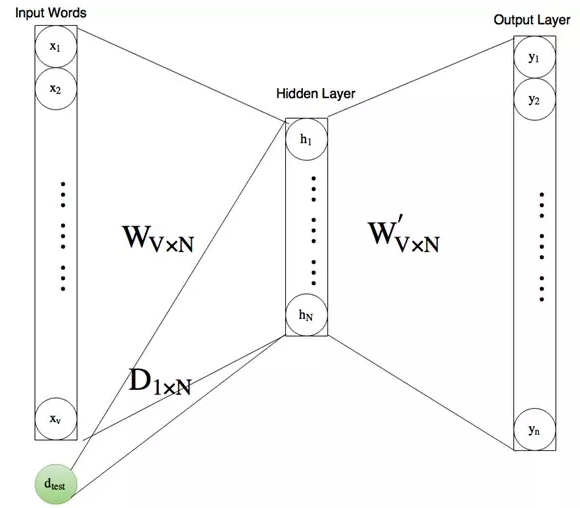

*Source: NITIN G, Twitter Sentiment Analysis - word2vec, doc2vec*

In [10]:
#Dividing the dataset into features and lables
tweets = df['text_clean']
labels = df['label']

tweets_split = []

for i, line in enumerate(tweets):
    # print(line)
    tweet = str(line).lower().split()
    tweets_split.append(tweet)

In [11]:
#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)

In [12]:
#lenght of tweet to consider
maxlentweet = 10
#add padding
X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)

(11000, 10)


In [13]:
# w2vModel = api.load('word2vec-google-news-300')

# Load the 'glove-twitter-100' pre-trained word embeddings
w2vModel = api.load('glove-twitter-100')

In [14]:
# Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)

# Length of tweet to consider
maxlentweet = 10
# Add padding
X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)

# Create an embedding layer using Google pre-trained word2vec (100-dimensional vectors)
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    if word in w2vModel.key_to_index:  # Check if the word is in the model's vocabulary
        embedding_matrix[i] = w2vModel.get_vector(word)

embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=maxlentweet)


(11000, 10)


# PCA Visualization

In [17]:
pca = PCA(n_components=2)  # Reduce the dimensions to 2 for visualization
embedding_matrix_2d = pca.fit_transform(embedding_matrix)

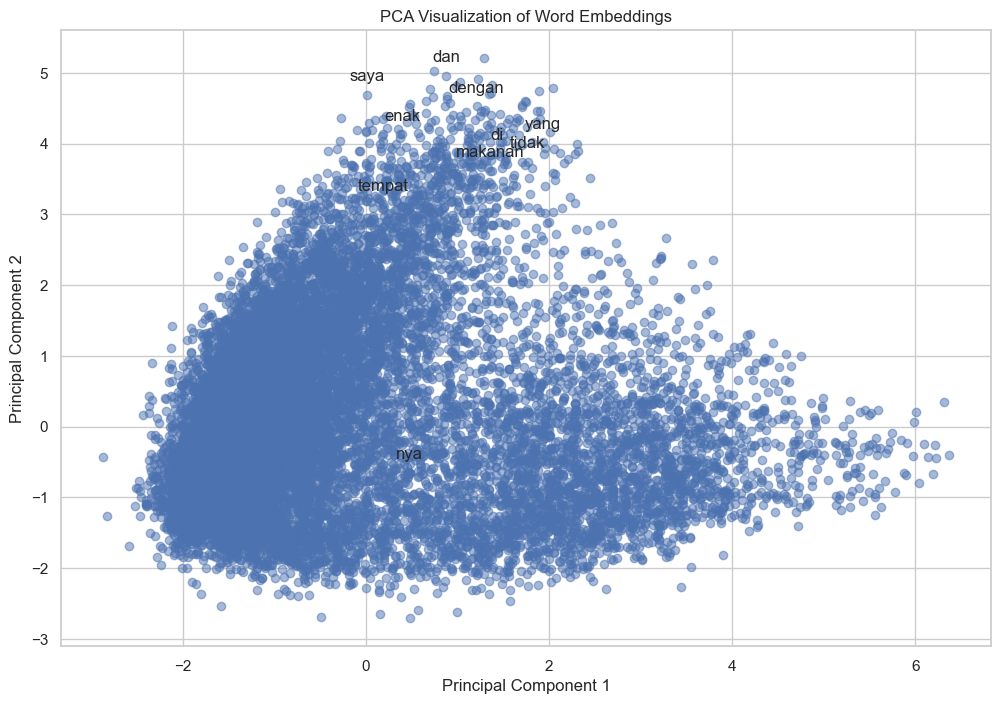

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], alpha=0.5)
plt.title("PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Optionally, annotate some points with words to explore
n_words_to_annotate = 10
words_to_annotate = list(tokenizer.word_index.keys())[:n_words_to_annotate]

for word, (x, y) in zip(words_to_annotate, embedding_matrix_2d[:n_words_to_annotate]):
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()


By saving the label encoder, tokenizer, and processed data, it can create a snapshot of entire data preprocessing pipeline. This is particularly useful to deploy the model in a different environment or share it with others, ensuring that the preprocessing steps are consistent with what the model was trained on.

Remember to load these saved components when you want to evaluate your model on new data or deploy it for predictions. it can use the pickle module's load function to load the saved objects back into the code.

In [19]:
X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

x_pad_sequences.pickle has created!
y_labels.pickle has created!


In [20]:
#Split Dataset For Training & Testing
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

# LSTM Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           10000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 10,235,267
Trainable params: 10,235,267
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
275/275 [==============================] - 6s 16ms/step - loss: 0.5653 - accuracy: 0.7594 - val_loss: 0.4139 - val_accuracy: 0.8286
Epoch 2/10
275/275 [==============================] - 3s 11ms/step - loss: 0.2636 - accuracy

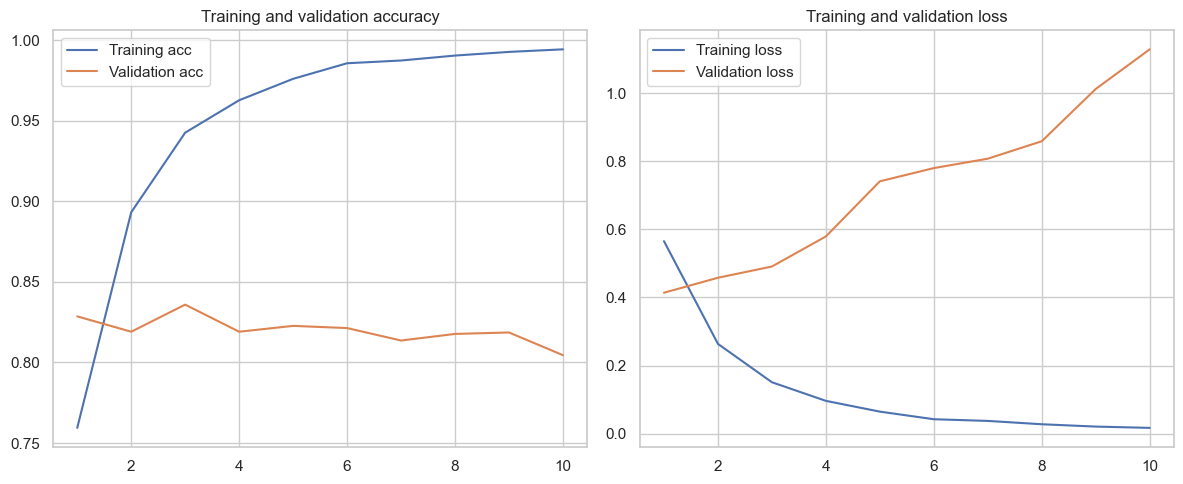

In [24]:
# Build the LSTM model
n_classes = 3  # Number of sentiment classes
embed_dim = 100
units = 128
max_features = 100000
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(units, dropout=0.2)))  # Use Bidirectional LSTM with more units
model.add(Dense(n_classes, activation='softmax'))  # Use softmax activation for multi-class
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Define a mapping for label conversion
label_mapping = {'positive': 2, 'negative': 1, 'neutral': 0}  # Adjust this mapping based on your labels

# Fit model
batch_size = 32
history = model.fit(X_train, Y_train, epochs=10, verbose=1, batch_size=batch_size,
                    validation_data=(X_test, Y_test))  # Providing validation data


# Analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
y_probs = model.predict(X_test)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming history is the history object obtained from model.fit
plot_history(history)

Classification scores are used to evaluate how well a classification model is performing:
1. Precision: Accuracy of positive predictions.
2. Recall: Ability to capture positive instances.
3. F1-Score: Balance between precision and recall.
4. Specificity: Ability to capture negative instances.

In [25]:
# Classification Scores for the main architecture model

# Get predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Convert one-hot encoded Y_test back to class labels
Y_test_classes = np.argmax(Y_test, axis=1)

# Generate classification report
classification_rep = classification_report(Y_test_classes, y_pred_classes, target_names=label_mapping.keys())
print("Classification Report:\n", classification_rep)

 1/69 [..............................] - ETA: 1s

69/69 [==============================] - 0s 5ms/step
Classification Report:
               precision    recall  f1-score   support

    positive       0.75      0.73      0.74       664
    negative       0.62      0.65      0.63       232
     neutral       0.86      0.87      0.87      1304

    accuracy                           0.80      2200
   macro avg       0.75      0.75      0.75      2200
weighted avg       0.80      0.80      0.80      2200



# *Cross-validation*

Cross-validation is a method in machine learning to assess and improve model performance. Rather than solely dividing data into training and testing portions, cross-validation divides it into multiple segments or folds. The model is trained on some folds and evaluated on others, cycling through all folds to obtain a comprehensive performance evaluation. This approach offers several benefits, including better performance estimation, reduced overfitting, efficient data utilization, hyperparameter tuning, understanding generalization capabilities, and identifying potential biases.

In [26]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

for iteration, data in enumerate(kf.split(X), start=1):

    data_train = X[data[0]]
    target_train = Y[data[0]]  # Use Y represents the one-hot encoded labels

    data_test = X[data[1]]
    target_test = Y[data[1]]  # Use Y which represents the one-hot encoded labels

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units=128, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(data_train, target_train, epochs=10, batch_size=10, verbose=1)

    predictions = model.predict(data_test)
    y_pred = predictions.argmax(axis=1)

    accuracy = accuracy_score(target_test.argmax(axis=1), y_pred)

    print("Training round", iteration)
    print(classification_report(target_test.argmax(axis=1), y_pred))
    print("======================================================")

    accuracies.append(accuracy)

# Calculate the average accuracy over all folds
average_accuracy = np.mean(accuracies)
print()
print()
print()
print()
print("Average Accuracy: ", average_accuracy)


Epoch 1/10
880/880 [==============================] - 9s 9ms/step - loss: 0.5297 - accuracy: 0.7844
Epoch 2/10
880/880 [==============================] - 8s 9ms/step - loss: 0.2677 - accuracy: 0.8970
Epoch 3/10
880/880 [==============================] - 7s 8ms/step - loss: 0.1606 - accuracy: 0.9353
Epoch 4/10
880/880 [==============================] - 8s 9ms/step - loss: 0.0992 - accuracy: 0.9591
Epoch 5/10
880/880 [==============================] - 7s 8ms/step - loss: 0.0630 - accuracy: 0.9780
Epoch 6/10
880/880 [==============================] - 7s 8ms/step - loss: 0.0370 - accuracy: 0.9880
Epoch 7/10
880/880 [==============================] - 7s 8ms/step - loss: 0.0261 - accuracy: 0.9908
Epoch 8/10
880/880 [==============================] - 8s 9ms/step - loss: 0.0212 - accuracy: 0.9926
Epoch 9/10
880/880 [==============================] - 8s 9ms/step - loss: 0.0135 - accuracy: 0.9955
Epoch 10/10
69/69 [==============================] - 1s 3ms/step
Training round 1
              prec

In [27]:
# Export Model
model_name = "LSTM_doc2vec"
model.save(model_name + '.h5')
print('Model has been saved!')

Model has been saved!


# *ROC AUC scores*

The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score are used to evaluate the performance of binary classification models, particularly in scenarios where there is a trade-off between true positive rate (sensitivity) and false positive rate (1-specificity).

The AUC score quantifies the overall performance of the classifier by calculating the area under the ROC curve. The AUC score ranges between 0 and 1, where:

1. AUC = 0.5: The model's performance is equivalent to random chance.
2. AUC > 0.5: The model is performing better than random.
3. AUC = 1: The model has perfect discriminatory ability.

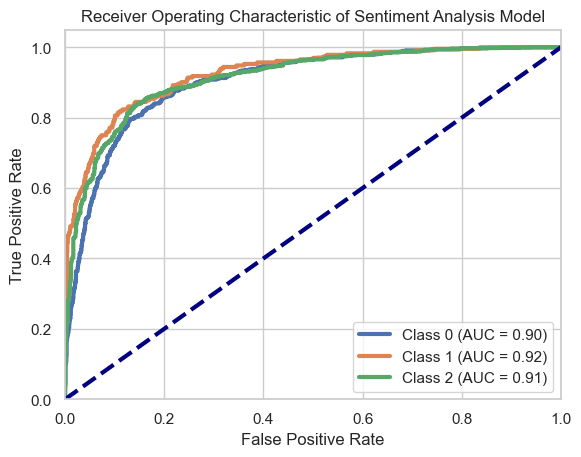

In [28]:
# Calculate ROC AUC scores for each class
roc_auc_scores = []
for class_idx in range(n_classes):
    roc_auc = roc_auc_score(Y_test[:, class_idx], y_probs[:, class_idx])
    roc_auc_scores.append(roc_auc)

# Plot ROC curves for each class
plt.figure()
for class_idx in range(n_classes):
    falsePositiveRate, truePositiveRate, _ = roc_curve(Y_test[:, class_idx], y_probs[:, class_idx])
    roc_auc = auc(falsePositiveRate, truePositiveRate)
    plt.plot(falsePositiveRate, truePositiveRate, lw=3, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiment Analysis Model')
plt.legend(loc="lower right")
plt.show()


# *Confusion Matrix*
Confusion Matrix provide a nice overlook at the model's performance in classification task

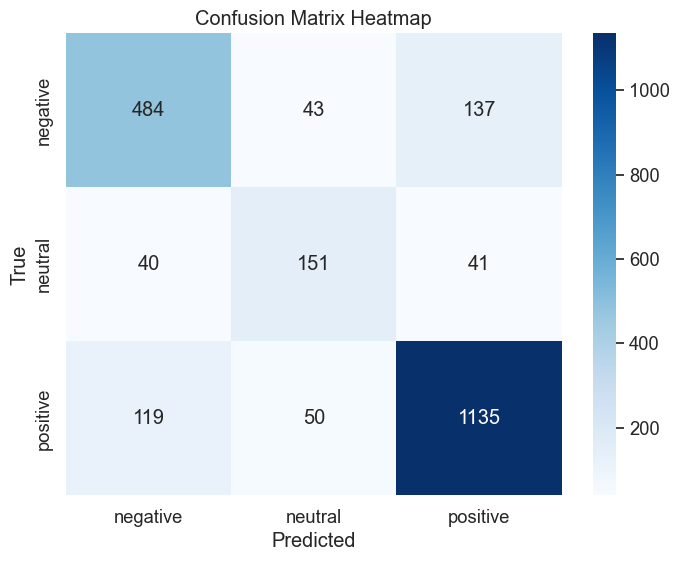

In [44]:
# You can convert the predicted probabilities to class labels
y_pred = np.argmax(y_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(Y_test, axis=1)
# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
# Define class labels (adjust according to your classes)
class_labels = ['negative', 'neutral', 'positive']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Model Testing

In [45]:
# Sample input text
input_text = """
Rasa syukur, cukup.
"""

# Define a function to clean and preprocess the input text
def clean_text(text):
    # Convert text to lowercase using the lower() function
    cleaned_text = text.lower()
    # Remove emoticons and punctuation using "RegEx" with the script below
    cleaned_text = re.sub(r'[^a-zA-Z0-9]', ' ', cleaned_text)
    return cleaned_text

# Define the possible sentiment labels
sentiment_labels = ['negative', 'neutral', 'positive']

# Clean and preprocess the input text
text = [clean_text(input_text)]

# Load the trained model
model_name = "LSTM_doc2vec"
model = load_model(model_name + '.h5')

# Tokenize and pad the input text for prediction
predicted = tokenizer.texts_to_sequences(text)
# X.shape[1] matches the model input length
guess = pad_sequences(predicted, maxlen=X.shape[1])  
# Make predictions using the loaded model
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

# Print the cleaned input text and the predicted sentiment label
print("Cleaned Text: ", text[0])
print("Predicted Sentiment: ", sentiment_labels[polarity])


1/1 [==============================] - 0s 287ms/step
Cleaned Text:   rasa syukur  cukup  
Predicted Sentiment:  positive
